#### Importing the libraries

In [1]:
# Importing the libraries

import yfinance as yf
import datetime

import numpy as np
import pandas as pd

import math

# data visualization library
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# To plot acf and pacf
import statsmodels.graphics.tsaplots as sgt

# adf Fuller
from statsmodels.tsa.stattools import adfuller

# min-max Scaler
from sklearn.preprocessing import MinMaxScaler
# var model
from statsmodels.tsa.api import VAR
# durbin watson statistic
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error, mean_absolute_error


#ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Problem Statement

Forecast the future trend of Crypto such as Bitcoin, Binance, Ethereum & Litecoin prices from their historical closing price and also explore the corelation between these multiple Crypocurrencies using Granger's Causality.



Generally, cryptocurrencies are positively correlated with one another. 
The correlation coefficient is particularly positive between Bitcoin and other crypto assets such as Binance, Ethereum, Litecoin, Doge etc  which is why crypto prices will usually rise across the board when BTC climbs and likewise falls when it tumbles. 



### 2. Input data

The input data is extracted from Yahoo Finance for Bitcoin (symbol = 'BTC-USD'), Ethereum(symbol = 'ETH-USD'),Binance(symbol = 'BNB-USD'),Litecoin(symbol = 'LTC-USD') using yfinance library for the past 5 years in the date range from '2018-05-01' to '2023-06-14'.

'yfinance' is a Python library that provides a convenient way to download and retrieve historical stock market data from Yahoo Finance. It allows you to access a wide range of financial data, including historical stock prices, trading volumes, dividends, and more. The library makes it easy to retrieve this data for multiple tickers and time periods.


In [2]:
stock = ['BTC-USD', 'ETH-USD','BNB-USD', 'LTC-USD'] #Specify the tickers
start = pd.to_datetime('2020-05-01')
end = pd.to_datetime('2023-06-14')
df = yf.download(stock, start = start,end=end )
print(df.head())

[*********************100%***********************]  4 of 4 completed
            Adj Close                                          Close  \
              BNB-USD      BTC-USD     ETH-USD    LTC-USD    BNB-USD   
Date                                                                   
2020-04-30  17.033976  8658.553711  207.602051  46.714020  17.033976   
2020-05-01  17.564993  8864.766602  214.219101  47.791702  17.564993   
2020-05-02  17.584904  8988.596680  215.325378  49.458046  17.584904   
2020-05-03  17.126299  8897.468750  210.933151  48.267159  17.126299   
2020-05-04  17.100756  8912.654297  208.174011  47.473492  17.100756   

                                                     High               ...  \
                BTC-USD     ETH-USD    LTC-USD    BNB-USD      BTC-USD  ...   
Date                                                                    ...   
2020-04-30  8658.553711  207.602051  46.714020  18.129528  9440.650391  ...   
2020-05-01  8864.766602  214.219101  4

In [3]:
# Extracting the Adjusted Closing Prices of the Crytocurrencies
data = df['Adj Close']
data.head()

,BNB-USD,BTC-USD,ETH-USD,LTC-USD
Date,,,,
2020-04-30,17.033976,8658.553711,207.602051,46.714020
2020-05-01,17.564993,8864.766602,214.219101,47.791702
2020-05-02,17.584904,8988.596680,215.325378,49.458046
2020-05-03,17.126299,8897.468750,210.933151,48.267159
2020-05-04,17.100756,8912.654297,208.174011,47.473492


In [4]:
# Looking at the last few rows of the data
data.tail()

,BNB-USD,BTC-USD,ETH-USD,LTC-USD
Date,,,,
2023-06-09,260.716095,26480.375000,1840.225220,89.232033
2023-06-10,239.089081,25851.240234,1752.384766,77.351707
2023-06-11,235.438797,25940.167969,1753.415283,77.698936
2023-06-12,231.051437,25902.500000,1742.528687,77.548096
2023-06-13,243.890533,25918.728516,1739.037598,77.443825


In [5]:
data.isnull().sum()

BNB-USD    0
BTC-USD    0
ETH-USD    0
LTC-USD    0
dtype: int64

### 3. Visualizing the Series

#### 3.1 Comparing the series on applying Normalization

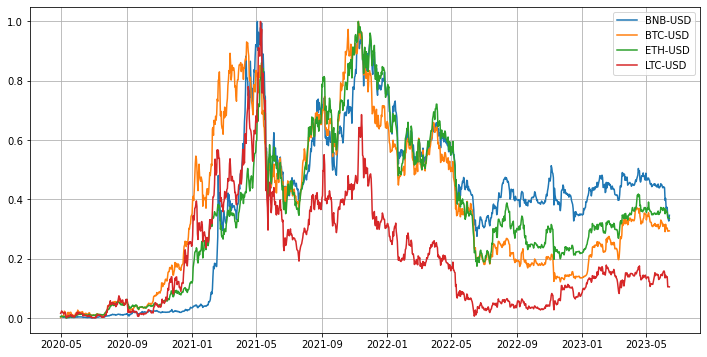

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
sdf_np = scaler.fit_transform(data)  
sdf = pd.DataFrame(sdf_np, columns=data.columns, index=data.index)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(sdf)
plt.legend(sdf.columns)
plt.show()

**Inference:** We can see high correlation among all the variables selected here. This makes a good candidate for multivariate VAR.

#### 3.2 Visualizing the Adjusted Closing prices 

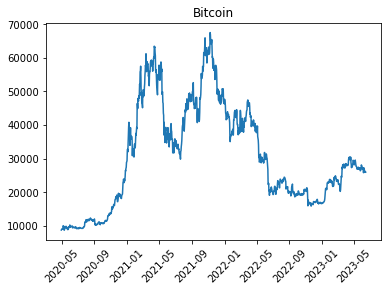

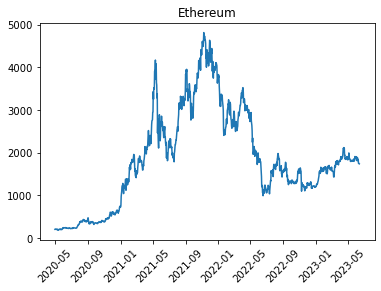

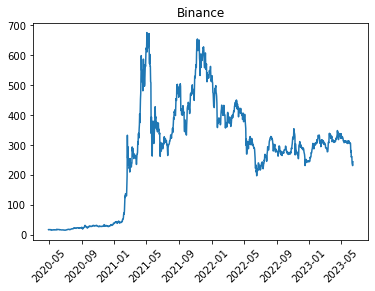

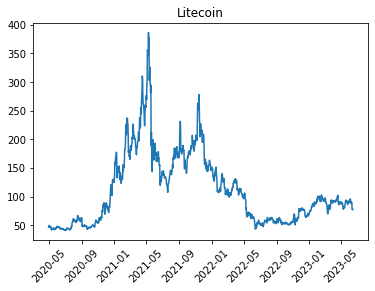

In [7]:
# Bitcoin
plt.plot(data['BTC-USD'])
plt.xticks(rotation=45)
plt.title("Bitcoin")
plt.show()


# Ethereum
plt.plot(data['ETH-USD'])
plt.xticks(rotation=45)
plt.title("Ethereum")
plt.show()

# Binance
plt.plot(data['BNB-USD'])
plt.xticks(rotation=45)
plt.title("Binance")
plt.show()

# Litecoin
plt.plot(data['LTC-USD'])
plt.xticks(rotation=45)
plt.title("Litecoin")
plt.show()

**Inference:** From the above plots, we can visible conclude that, all the series contain unit root with stochastic trend showing a systematic pattern that is unpredictable.

#### 3.3 Rolling window plot

We can also diagnose the correlation by measuring the average linear correlation over the rolling window in a function of rolling window size. Taking window size of 5 and 20 days for our observation.

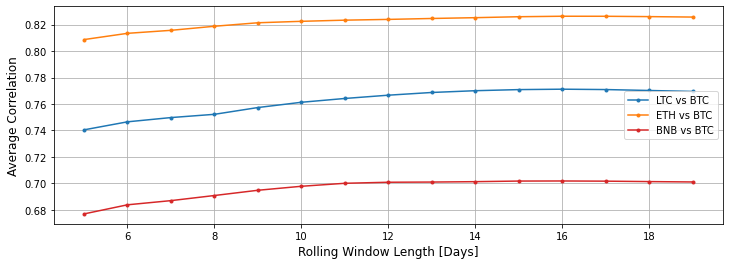

In [8]:
blue, orange, red, green = '#1f77b4', '#ff7f0e', '#d62728', '#454B1B'  # color codes
plt.figure(figsize=(12,4))
plt.grid()
cor1, cor2, cor3, cor4 = list(), list(), list(), list()
# average correlation for increasing rolling window size
for win in range(5, 20):  # Days
    cor1.append(data['LTC-USD'].rolling(win).corr(data['BTC-USD']) \
    .replace([np.inf, -np.inf], np.nan).dropna().mean())
    cor2.append(data['ETH-USD'].rolling(win).corr(data['BTC-USD']) \
    .replace([np.inf, -np.inf], np.nan).dropna().mean())
    cor3.append(data['BNB-USD'].rolling(win).corr(data['BTC-USD']) \
    .replace([np.inf, -np.inf], np.nan).dropna().mean())

       
plt.plot(range(5, 20), cor1, '.-', color=blue, label='LTC vs BTC')
plt.plot(range(5, 20), cor2, '.-', color=orange, label='ETH vs BTC')
plt.plot(range(5, 20), cor3, '.-', color=red, label='BNB vs BTC')
#plt.plot(range(5, 20), cor4, '.-', color=red, label='LTC vs BTC')
plt.legend()
plt.xlabel('Rolling Window Length [Days]', fontsize=12)
plt.ylabel('Average Correlation', fontsize=12)
plt.show()

#### 3.4. Understanding the Correlation between all the selected series using Heatmap

<AxesSubplot:>

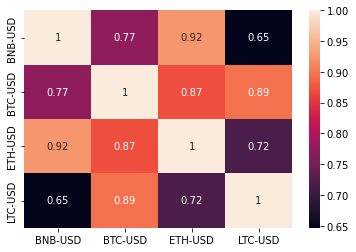

In [9]:
corr = data.corr()
sns.heatmap(corr, annot=True)

**Inference**: Litecoin and Ethereum has shown the highest correlation with Bitcoin with a score of 0.89 and 0.87 respectively

### 4. Autocorrelation plots

#### Ploting the acf and pacf plot for the various Crypto series

Bitcoin ACF and PACF


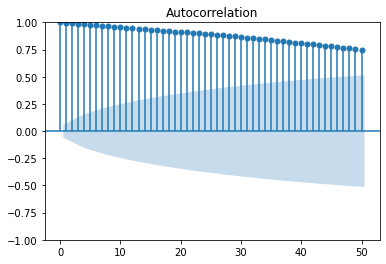

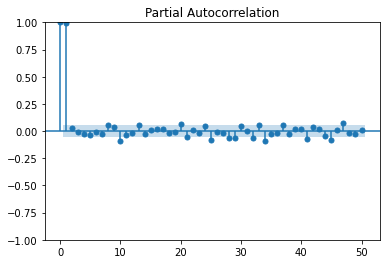

In [10]:
print("Bitcoin ACF and PACF")
sgt.plot_acf(data['BTC-USD'], lags=50)
plt.show()
sgt.plot_pacf(data['BTC-USD'], lags=50)
plt.show()

Ethereum ACF and PACF


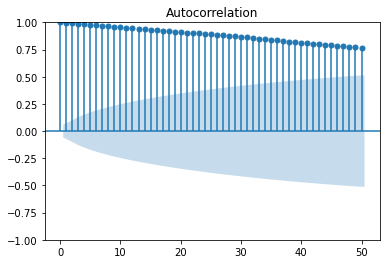

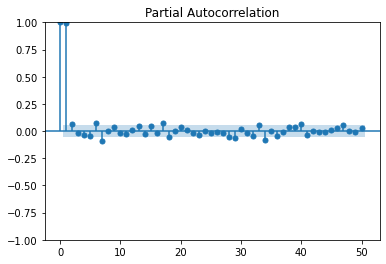

In [11]:
print("Ethereum ACF and PACF")
sgt.plot_acf(data['ETH-USD'], lags=50)
plt.show()
sgt.plot_pacf(data['ETH-USD'], lags=50)
plt.show()

Litecoin ACF and PACF


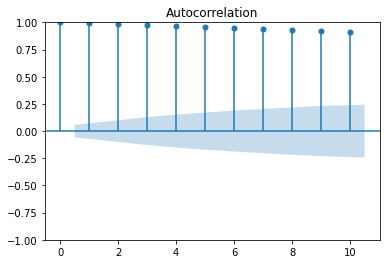

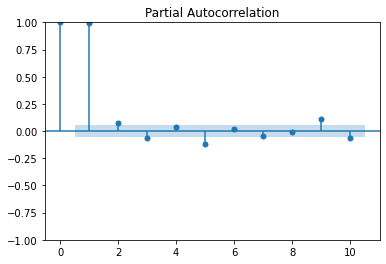

In [12]:
print("Litecoin ACF and PACF")
sgt.plot_acf(data['LTC-USD'], lags=10)
plt.show()
sgt.plot_pacf(data['LTC-USD'], lags=10)
plt.show()

Binance ACF and PACF


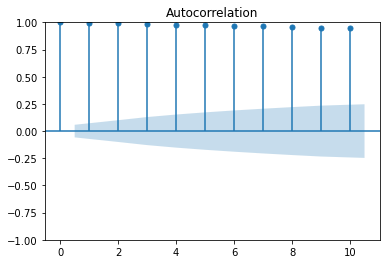

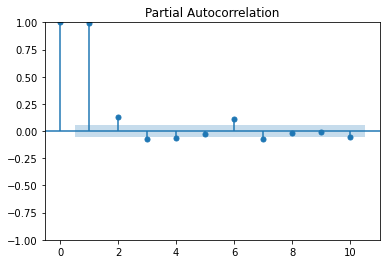

In [13]:
print("Binance ACF and PACF")
sgt.plot_acf(data['BNB-USD'], lags=10)
plt.show()
sgt.plot_pacf(data['BNB-USD'], lags=10)
plt.show()

### 5. Testing the Stationarity using Augmented Dicky Fuller Test:

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are no. of unit root tests and ADF is one of the most widely used

1. Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.

2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value:

1. p value > 0.05 : Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.

2. p value < = 0.05 : Rejects the Null Hypothesis (H0), the data is stationary.

In [14]:
def test_stationarity(x):

    #Perform Dickey Fuller test        
    print('Results of Dickey-Fuller Test:')
    result = adfuller(x, autolag='AIC')
    df_result = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
     #   df_result['Critical Value (%s)'%key] = value
    print (df_result)

In [15]:
for i in data.columns:
    print(i)
    test_stationarity(data[i])
    print("\n")

BNB-USD
Results of Dickey-Fuller Test:
Test Statistic                   -1.939695
p-value                           0.313624
Number of Lags Used               6.000000
Number of Observations Used    1133.000000
dtype: float64


BTC-USD
Results of Dickey-Fuller Test:
Test Statistic                   -1.734385
p-value                           0.413489
Number of Lags Used               0.000000
Number of Observations Used    1139.000000
dtype: float64


ETH-USD
Results of Dickey-Fuller Test:
Test Statistic                   -1.875733
p-value                           0.343562
Number of Lags Used               6.000000
Number of Observations Used    1133.000000
dtype: float64


LTC-USD
Results of Dickey-Fuller Test:
Test Statistic                   -1.811842
p-value                           0.374598
Number of Lags Used              15.000000
Number of Observations Used    1124.000000
dtype: float64




Since the **p-value** for all the series is geater than 0.05, we hereby accept the Null Hypotheis that the series is non-stationary.

#### 6. Making the series Stationary

Unlike ARIMA, a stationary series is needed before we apply VAR model to our multivariate data.
So, we are performing first order differencing on training set to make all the series stationary. However, we need to understand that this is an iterative process where after performing first differencing, the series may still be non-stationary. We then have to apply second difference or log transformation to standardize the series in such cases.

In [16]:
for i in data.columns:
    data[i] = data[i] - data[i].shift()
data.dropna(inplace=True)

In [17]:
# Perform ADF test again after the transformation

for i in data.columns:
    print(i)
    test_stationarity(data[i])
    print("\n")

BNB-USD
Results of Dickey-Fuller Test:
Test Statistic                -1.346059e+01
p-value                        3.536382e-25
Number of Lags Used            5.000000e+00
Number of Observations Used    1.133000e+03
dtype: float64


BTC-USD
Results of Dickey-Fuller Test:
Test Statistic                -1.058886e+01
p-value                        6.607573e-19
Number of Lags Used            8.000000e+00
Number of Observations Used    1.130000e+03
dtype: float64


ETH-USD
Results of Dickey-Fuller Test:
Test Statistic                -1.293670e+01
p-value                        3.605261e-24
Number of Lags Used            5.000000e+00
Number of Observations Used    1.133000e+03
dtype: float64


LTC-USD
Results of Dickey-Fuller Test:
Test Statistic                -1.090504e+01
p-value                        1.133772e-19
Number of Lags Used            1.400000e+01
Number of Observations Used    1.124000e+03
dtype: float64




#### 6.1 Plots after First Order Differencing the series

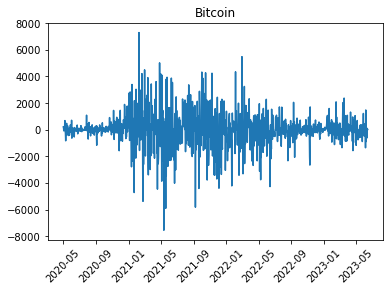

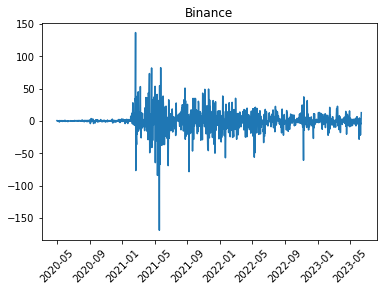

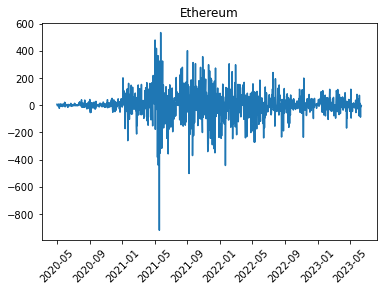

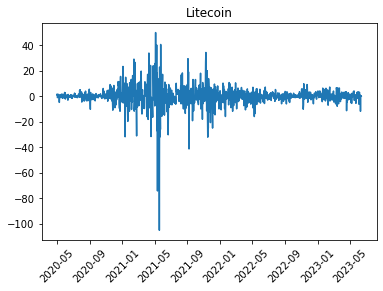

In [18]:
plt.plot(data['BTC-USD'])
plt.xticks(rotation=45)
plt.title("Bitcoin")
plt.show()

plt.plot(data['BNB-USD'])
plt.xticks(rotation=45)
plt.title("Binance")
plt.show()

plt.plot(data['ETH-USD'])
plt.xticks(rotation=45)
plt.title("Ethereum")
plt.show()

plt.plot(data['LTC-USD'])
plt.xticks(rotation=45)
plt.title("Litecoin")
plt.show()

We notice that all the p-values are less than the significance level i.e 0.05 (p<0.05). This means that the series is stationary. Once the individual series is stationary, we can go ahead with the modelling process to forecast the trend of adjusted closing prices. 

#### 6.2 Plotting the differenced data

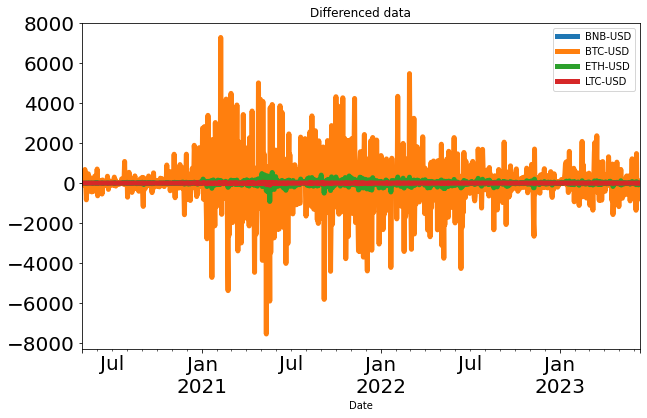

In [19]:
data.plot(figsize=(10,6), linewidth=5, fontsize=20)
plt.title('Differenced data')
plt.show()

### 7. Testing Causality using Granger's Causality Test

Using Granger’s Causality Test, it’s possible to test if each of the time series in the system influences each other. Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero. VAR models can also be used for analyzing the relation between the variables involved using Granger Causality tests. Granger causality speciﬁes that a variable y1t is causal for a variable y2t if the information in y1t is helpful for improving the forecasts of y2t.

Granger Causality tests try to determine if one variable(x1) can be used as a predictor of another variable(x2) where the past values of that another variable may or may not help. This means that x1 explains beyond the past values of x2. Two important assumptions here are:

####  1) both x1 and x2 are stationary

#### 2) there exists a linear relation between their current and past values.



This means that if x1 and x2 are non-stationary, we have to make them stationary before testing for Granger Causality.

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(data, variables = data.columns)  

,BNB-USD_x,BTC-USD_x,ETH-USD_x,LTC-USD_x
BNB-USD_y,1.0000,0.0006,0.0096,0.0
BTC-USD_y,0.0000,1.0000,0.0001,0.0
ETH-USD_y,0.0106,0.0000,1.0000,0.0
LTC-USD_y,0.0000,0.0001,0.0000,1.0


**Inference**: 
The row are the response (y) and the columns are the predictors (x). If a given p-value is < significance level (0.05), for example, take the value 0.0 in (row 3, column 2), we can reject the null hypothesis and conclude that BTC-USD_x Granger causes ETH-USD_y. Likewise, the 0.0106 (approx. 0.05) in (row 3, column 1) refers to Ethereum, ETH-USD_y Granger causes BTC-USD_x i.e Bitcoin (BTC-USD).

All the time series in the above data are interchangeably Granger causing each other.

### 8. Split the data

We keep last 15 observation in our test set and rest of the data as the training set

In [21]:
n_obs=15
X_train, X_test = data[0:-n_obs], data[-n_obs:]
print(X_train.shape, X_test.shape)

(1124, 4) (15, 4)


### 9. Model Building

#### 9.1 Select the Order(p) of VAR model

In [22]:
model = VAR(X_train)
for i in range(0, 10):
    result = model.fit(i)
    print('Lag Order=', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC : ', result.hqic, '\n')

Lag Order= 0
AIC :  30.57449954475279
BIC :  30.592380858028424
FPE :  18981758341579.152
HQIC :  30.581257019869472 

Lag Order= 1
AIC :  30.55801122885721
BIC :  30.647481557525747
FPE :  18671351584064.785
HQIC :  30.591824177685925 

Lag Order= 2
AIC :  30.533159520853207
BIC :  30.69432106372217
FPE :  18213075702052.97
HQIC :  30.594068934363655 

Lag Order= 3
AIC :  30.53493066628868
BIC :  30.767885861649745
FPE :  18245413066743.195
HQIC :  30.622977634082336 

Lag Order= 4
AIC :  30.516703864671026
BIC :  30.8215553910743
FPE :  17915962501080.65
HQIC :  30.63192957530492 

Lag Order= 5
AIC :  30.489121572451566
BIC :  30.865972349483027
FPE :  17428696738079.576
HQIC :  30.631567313763405 

Lag Order= 6
AIC :  30.47341194559111
BIC :  30.92236513465328
FPE :  17157247096362.615
HQIC :  30.643119105025765 

Lag Order= 7
AIC :  30.473290716656706
BIC :  30.99444972175252
FPE :  17155456493462.402
HQIC :  30.670300781594033 

Lag Order= 8
AIC :  30.467487231877396
BIC :  31.060

#### 9.2 Intiate the VAR model

In [23]:
model = VAR(endog=X_train)
res = model.select_order(6)
res.summary()

,AIC,BIC,FPE,HQIC
0,30.60,30.61*,1.939e+13,30.60*
1,30.58,30.67,1.900e+13,30.61
2,30.55,30.71,1.847e+13,30.61
3,30.55,30.78,1.844e+13,30.63
4,30.52,30.83,1.804e+13,30.64
5,30.49,30.87,1.749e+13,30.64
6,30.47*,30.92,1.716e+13*,30.64


From the model summary above, the AIC score increases till the 4th lag beyond which it decreases. We then conclude that the best lag order to use for our model is 6. VAR model will be built with optimum lags recommended by AIC i.e 6 lags.

### 9.3 Train the VAR model

In [24]:
mod = VAR(X_train)
res = mod.fit(maxlags=6, ic='aic')
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Aug, 2023
Time:                     12:31:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    30.9224
Nobs:                     1118.00    HQIC:                   30.6431
Log likelihood:          -23280.1    FPE:                1.71572e+13
AIC:                      30.4734    Det(Omega_mle):     1.57047e+13
--------------------------------------------------------------------
Results for equation BNB-USD
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.265551         0.473054            0.561           0.575
L1.BNB-USD        -0.128185         0.045945           -2.790           0.005
L1.BTC-USD         0.001317         0.000652            2.021         

### 10. Forecast VAR Model

The forecasts are generated on the training data used by the model.

In [25]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)

# Input data for forecasting
input_data = X_train.values[-lag_order:]
print(input_data)

6
[[-7.57345581e+00 -8.90908203e+02 -5.42806396e+01 -5.63196564e+00]
 [-1.19912720e+00  1.41388672e+02  5.85375977e+00  6.00311279e-01]
 [ 2.15267944e+00  2.43083984e+02  2.27359619e+01  6.67388916e-01]
 [ 7.05444336e-01  1.49062500e+02  2.42858887e+00  1.38224792e+00]
 [ 6.67828369e+00  1.21729297e+03  7.97958984e+01  2.92964935e+00]
 [-2.46286011e+00 -3.39761719e+02 -1.78360596e+01 -5.79505920e-01]]


In [26]:
# forecasting

pred = res.forecast(y=input_data, steps=n_obs)
print(pred.shape)

pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

(15, 4)
            BNB-USD_pred  BTC-USD_pred  ETH-USD_pred  LTC-USD_pred
Date                                                              
2023-05-30     -0.861719     -0.020343     -1.177771     -0.049806
2023-05-31      1.682861    105.045444      7.491436      0.443331
2023-06-01      0.432745     42.594813      3.960217      0.150594
2023-06-02     -0.399955     26.469732     -1.846033     -0.465087
2023-06-03      0.913605    108.837880      8.558743      0.803685
2023-06-04      0.174981     -0.816906      1.001391     -0.056893
2023-06-05      0.232188     18.488538      0.673622      0.010611
2023-06-06      0.272967     10.558372      1.840453     -0.024298
2023-06-07      0.513603     36.264227      2.229307      0.177803
2023-06-08      0.035844     19.577147      1.588041      0.013341
2023-06-09      0.386644     17.967509      1.568242      0.058810
2023-06-10      0.261440     15.288620      1.752291      0.039721
2023-06-11      0.229074     15.912219      1.122639  

### 10.1 - Invert Transformation

So, to bring it back up to its original scale, we need to de-difference to the original input data. Our data was first order differenced to make it stationary.So, to inverse, we have to first use cumulative sum to de-differentiate.

In [27]:
def invert_transformation(X_train, pred_df):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col) +'_pred'].cumsum()
    return forecast

In [28]:
output = invert_transformation(X_train, pred)
print(output)

            BNB-USD_pred  BTC-USD_pred  ETH-USD_pred  LTC-USD_pred
Date                                                              
2023-05-30     -3.324579   -339.782062    -19.013830     -0.629312
2023-05-31     -1.641718   -234.736618    -11.522394     -0.185980
2023-06-01     -1.208972   -192.141805     -7.562178     -0.035386
2023-06-02     -1.608928   -165.672073     -9.408211     -0.500473
2023-06-03     -0.695323    -56.834193     -0.849468      0.303212
2023-06-04     -0.520342    -57.651099      0.151923      0.246319
2023-06-05     -0.288154    -39.162561      0.825545      0.256930
2023-06-06     -0.015187    -28.604190      2.665998      0.232632
2023-06-07      0.498416      7.660037      4.895304      0.410435
2023-06-08      0.534259     27.237184      6.483345      0.423776
2023-06-09      0.920903     45.204693      8.051587      0.482586
2023-06-10      1.182343     60.493313      9.803878      0.522307
2023-06-11      1.411418     76.405532     10.926517      0.55

### 11 - Evaluate the performance of the model

#### 11.1 - Plot of Predicted Vs. Actuals Bitcoin Price

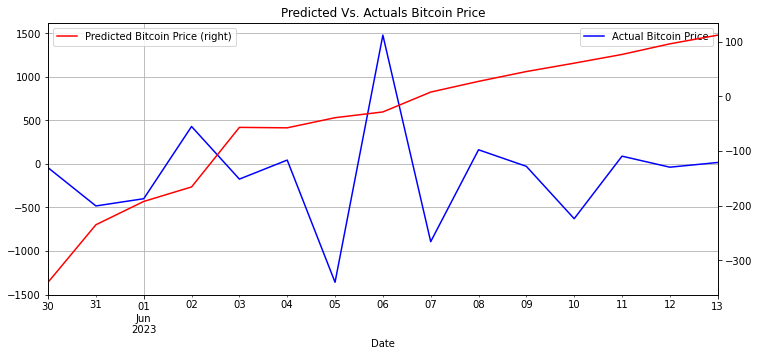

In [29]:
plt.figure(figsize = (12, 5))
plt.xlabel('Date')

ax1 = X_test['BTC-USD'].plot(color= 'blue', grid=True, label='Actual Bitcoin Price')
ax2 = output['BTC-USD_pred'].plot(color= 'red', grid=True, secondary_y = True, label='Predicted Bitcoin Price')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs. Actuals Bitcoin Price')
plt.show()

#### 11.2 - Evaluate the performance of the model using metrics

In [30]:
#Calculate mean absolute error
mae = mean_absolute_error(X_test['BTC-USD'],output['BTC-USD_pred'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(X_test['BTC-USD'],output['BTC-USD_pred'])
print('MSE: %f' % mse)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 428.858418
MSE: 394778.504867
RMSE: 628.314018


**Inference:** We have used Root Mean Square Error(RMSE) as the error metric. RMSE signifies the average distance between predicted points on the test set and the actual (true) labels. In other words, it shows the extent of our error. The less this number, the better. We can see, that our model’s RMSE is not very big (consider that the price in our data set is in thousands of USD, and we are mistaken only by tens of USD).

### 12. Impulse Response

All the variables in a VAR model depend on each other; therefore, individual coefficient estimates provide limited information on the reaction of the system to a shock. Hence, the need for impulse responses, which provide information about the dynamic behaviour of a VAR model. Subsequently, the purpose of an impulse response function (IRF) is to describe the evolution of a VAR model’s reaction to a shock in one or more variables.

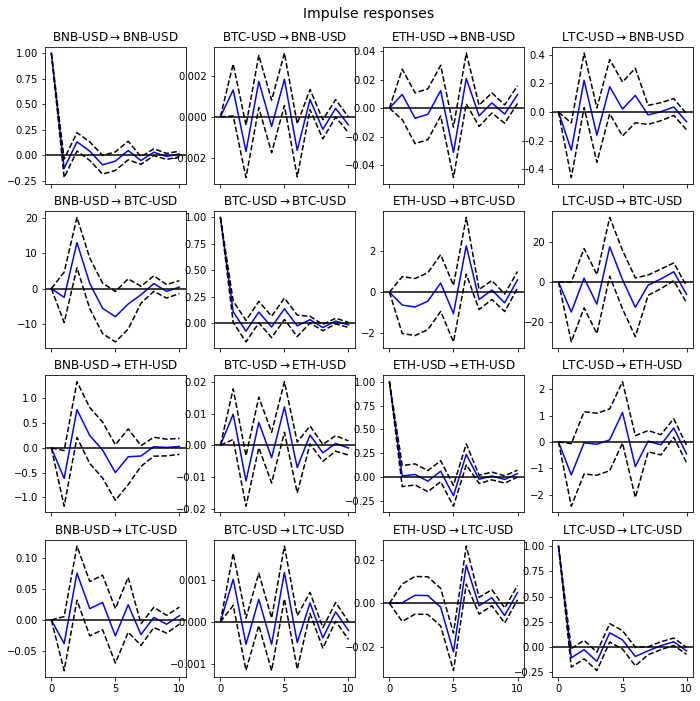

In [36]:
irf = res.irf(10)
irf.plot()
plt.show()

It can be seen that, the responses to the shocks are captured here, and they die down to almost after 10th lag.